# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [5]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [6]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [7]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [8]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

In [9]:
loss

2.30062671713171

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [10]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

In [11]:
loss_with_reg

2.39376835938139

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [12]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?

predict = model_with_reg.predict(train_X[:30])
accuracy = multiclass_accuracy(predict, train_y[:30]) 
print(predict)
print(accuracy)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
0.1


In [13]:
train_y[:30]

array([9, 9, 2, 1, 7, 1, 3, 5, 3, 6, 4, 2, 9, 1, 0, 7, 2, 1, 4, 7, 5, 9,
       5, 3, 8, 9, 6, 6, 5, 1], dtype=uint8)

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [14]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.217057, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.157437, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.115648, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287707, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.176635, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.070778, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.389343, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.201810, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268138, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.177243, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.188959, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288565, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324022, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.376680, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.181966, Train acc

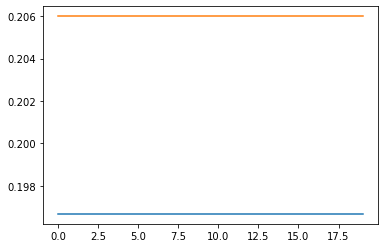

In [16]:
plt.plot(train_history)
plt.plot(val_history)

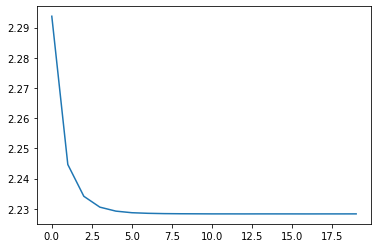

In [17]:
plt.plot(loss_history)

In [18]:
loss_history

[2.293779475027057,
 2.2446574973160707,
 2.2341269995546558,
 2.23053063846768,
 2.229210084825938,
 2.2286825538236155,
 2.228488236029909,
 2.2283866320264107,
 2.228343289791631,
 2.2283223205455633,
 2.228299402938629,
 2.228299378834099,
 2.228289790777959,
 2.228297508772213,
 2.228294507159288,
 2.228292236965843,
 2.2282864044611386,
 2.2282931111865123,
 2.228294168642701,
 2.2282980660725706]

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [19]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.250718, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.369552, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209789, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258964, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.186690, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.206852, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.121010, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.318011, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306481, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283265, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.162541, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.190528, Train accuracy: 0.201444, val accuracy: 0.209000
Loss: 2.418402, Train accuracy: 0.225111, val accuracy: 0.225000
Loss: 1.993465, Train accuracy: 0.239444, val accuracy: 0.244000
Loss: 2.450466, Train accuracy: 0.261667, val accuracy: 0.260000
Loss: 2.124529, Train acc

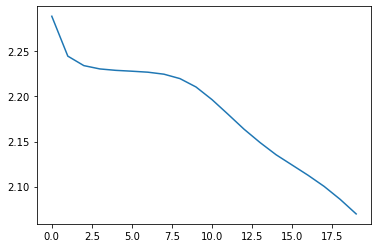

In [20]:
plt.plot(loss_history)

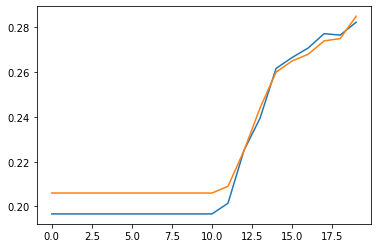

In [21]:
plt.plot(train_history)
plt.plot(val_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [22]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(0.82), learning_rate=1e-1, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.193672, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.159158, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.362453, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.954372, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.084757, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.340643, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.123311, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.204020, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.147330, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.206428, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.181630, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306145, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.141950, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265118, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258113, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.221820, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [23]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, MomentumSGD(0.8), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.358927, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.297174, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.199254, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.351908, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.138689, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.241398, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.455596, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.448811, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.674330, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.380557, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.524056, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.664383, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.547450, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.794625, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.633323, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.167038, Train acc

Loss: 1.130968, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.093457, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.059147, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.393860, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.448708, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.226422, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.146455, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.297220, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.133366, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 1.845380, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.118356, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.187415, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.318082, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.118062, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.236742, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.322334, Train acc

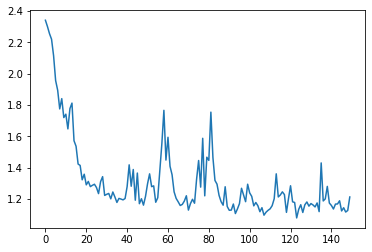

In [24]:
plt.plot(loss_history)

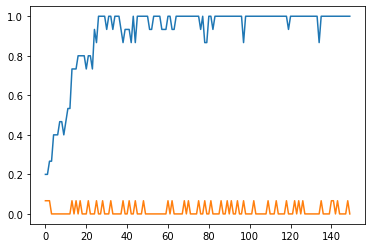

In [25]:
plt.plot(train_history)
plt.plot(val_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [26]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.099)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(0.9), learning_rate=0.1, learning_rate_decay=0.9, num_epochs=20, batch_size=3)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.323962, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.249070, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 1.717791, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.698562, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.308833, Train accuracy: 0.266667, val accuracy: 0.200000
Loss: 3.838056, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 3.220598, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 4.261522, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.850922, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 8.409661, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 7.726522, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.565855, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 3.820199, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.962698, Train accuracy: 0.933333, val accuracy: 0.066667
Loss: 2.146364, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 1.907788, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [27]:
data_size

15

In [28]:
# Let's train the best one-hidden-layer network we can
learning_rate = 1e-2
reg_strength =  1e-1
learning_rate_decay = 0.999
hidden_layer_size = 100
num_epochs = 150
batch_size = 20


model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, 
                    hidden_layer_size = hidden_layer_size, 
                    reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), 
                  learning_rate = learning_rate,
                  learning_rate_decay=0.99,
                  num_epochs=num_epochs, 
                  batch_size=batch_size)

loss_history, train_history, val_history = trainer.fit()

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above


Loss: 2.317265, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.120320, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.360854, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233196, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.152711, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336288, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294464, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311568, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.137975, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.252229, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302206, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321105, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.379202, Train accuracy: 0.216889, val accuracy: 0.222000
Loss: 2.001821, Train accuracy: 0.238778, val accuracy: 0.245000
Loss: 1.994850, Train accuracy: 0.252889, val accuracy: 0.251000
Loss: 2.203878, Train acc

Loss: 1.249037, Train accuracy: 0.726556, val accuracy: 0.712000
Loss: 1.444075, Train accuracy: 0.729667, val accuracy: 0.705000
Loss: 1.198470, Train accuracy: 0.728889, val accuracy: 0.706000
Loss: 0.983239, Train accuracy: 0.732111, val accuracy: 0.703000
Loss: 1.433235, Train accuracy: 0.732556, val accuracy: 0.706000
Loss: 1.312031, Train accuracy: 0.731444, val accuracy: 0.704000
Loss: 1.398053, Train accuracy: 0.732444, val accuracy: 0.711000
Loss: 1.197801, Train accuracy: 0.732111, val accuracy: 0.707000
Loss: 0.914660, Train accuracy: 0.733556, val accuracy: 0.704000
Loss: 1.343147, Train accuracy: 0.733444, val accuracy: 0.710000
Loss: 0.996848, Train accuracy: 0.735889, val accuracy: 0.706000
Loss: 1.084758, Train accuracy: 0.734667, val accuracy: 0.709000
Loss: 1.087854, Train accuracy: 0.738000, val accuracy: 0.715000
Loss: 1.141516, Train accuracy: 0.735667, val accuracy: 0.707000
Loss: 1.172964, Train accuracy: 0.738889, val accuracy: 0.708000
Loss: 1.170491, Train acc

In [30]:
best_val_accuracy = np.max(val_history)
print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.717000


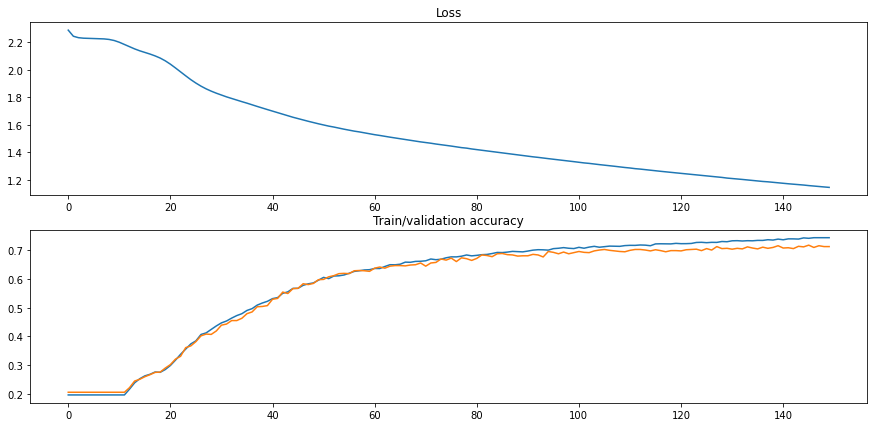

In [31]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [32]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.657000
